## Import Libraries

In [1]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage, AverageDollarVolume

from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.classifiers.fundamentals import Sector  

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.fundamentals import IsPrimaryShare

from quantopian.pipeline.data.psychsignal import stocktwits

from quantopian.pipeline.filters.morningstar import Q1500US

import alphalens as al

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Declare Statics

In [30]:
# statics
BASE_UNIVERSE = Q1500US()
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}
START='2017-01-30'
END='2017-01-30'
WINLENGTH=30
# START='2011-01-01'
# END='2017-28-09'

## Define Custom Classes

In [5]:
# class Dvd_And_Payout(CustomFactor):
    
#     inputs = [morningstar.valuation_ratios.dividend_yield,
#               morningstar.valuation_ratios.payout_ratio]
    
#     window_length = 1
        
#     def compute(self, today, assets, out, dividend_yield, payout_ratio):
#         out_df = pd.DataFrame(index=assets)
#         value_table["dividend_yield"] = dividend_yield[-1]
#         value_table["payout_ratio"] = payout_ratio[-1]
#         out[:] = value_table.rank().mean(axis=1)

In [6]:
# class dvd_nonzero_zscore(CustomFactor):
#     inputs = [morningstar.valuation_ratios.dividend_yield]
#     window_length = 1

#     def compute(self, today, assets, out, dividend_yield, payout_ratio):
#         df = pd.DataFrame(index=assets)
#         df["dividend_yield"] = dividend_yield[-1].zscore(mask=payout_ratio>0)
#         out[:] = value_table

In [7]:
# class tweets(CustomFactor):
#     inputs=[stocktwits.bull_bear_msg_ratio]
#     window_length=1
    
#     def compute(self, today, assets, out, bull_bear_msg_ratio):
#         value_table = pd.DataFrame(index=assets)
#         value_table['total_tweets']=bull_bear_msg_ratio[-1]
#         out[:]=value_table.mean()

In [3]:
class Price_Change_1M(CustomFactor):
    
    inputs = [USEquityPricing.close]
    window_length = 252
    
    def compute(self, today, assets, out, close):       
        out[:] = close[0] / close[-30] - 1

## Define custom plotting

In [4]:
def diagplot(plotdf, title='title'):
    f,ax=plt.subplots(nrows=len(plotdf.columns),figsize=(10,17),sharex=True)

    for j,c in enumerate(plotdf.dropna()):
        plotdf.dropna()[c].plot(ax=ax[j])
        ax[j].set_ylabel(c)

    f.suptitle(title,fontsize=20,y=0.92)
    
    return ax

## Define Pipeline

In [5]:
def raw_pipe():
    # Load Factors
    pb_ratio=morningstar.valuation_ratios.pb_ratio.latest
    
    dvd=morningstar.valuation_ratios.dividend_yield.latest
    
    payout=morningstar.valuation_ratios.payout_ratio.latest
        
    price_change=Price_Change_1M()
    
    bull_bear_ratio_tweets=stocktwits.bull_bear_msg_ratio.latest

    # Make Filters
    mkt_cap_lower = morningstar.valuation.market_cap.latest >= 250000000 # $250MM
    mkt_cap_upper = morningstar.valuation.market_cap.latest <= 5000000000 # $2 Billion 
    price_filter = USEquityPricing.close.latest >= 5
    tweet_filter = ~bull_bear_ratio_tweets.isnan()
    
    allfilters=mkt_cap_lower & mkt_cap_upper & price_filter
    
    # Apply Filters
    universe = BASE_UNIVERSE & allfilters

    return Pipeline( columns={'pb_ratio_raw':pb_ratio,
                              'dvd_raw':dvd,
                              'payout_raw': payout,
                              'price_change_raw':price_change,
                              'bull_bear_ratio_tweets_raw':bull_bear_ratio_tweets,
#                               'Sector' : Sector()
                             },
                     screen=universe # screen pipeline output on filtered BASE_UNIVERSE
                   )

In [33]:
sma_kwargs=dict(window_length=WINLENGTH,mask=BASE_UNIVERSE)

In [34]:
def dev_pipe():
    
    # Construct Factors.
    sma_pb = SimpleMovingAverage(inputs=[morningstar.valuation_ratios.pb_ratio],**sma_kwargs)
    sma_dvd = SimpleMovingAverage(inputs=[morningstar.valuation_ratios.dividend_yield],**sma_kwargs)
    sma_payout = SimpleMovingAverage(inputs=[morningstar.valuation_ratios.payout_ratio],**sma_kwargs)
#     sma_price_change = SimpleMovingAverage(inputs=[Price_Change_1M(window_length=252)], 
#                                            window_length=WINLENGTH)
    sma_tweets = SimpleMovingAverage(inputs=[stocktwits.bull_bear_msg_ratio], **sma_kwargs)

    # Make Filters
    mkt_cap_lower = morningstar.valuation.market_cap.latest >= 250000000 # $250MM
    mkt_cap_upper = morningstar.valuation.market_cap.latest <= 5000000000 # $5 Billion 
    price_filter = USEquityPricing.close.latest >= 5
    
    pb_filter=(sma_pb<=15)
    dvd_filter=(sma_dvd<=0.2)
    payout_filter=(sma_payout<=0.5)
    tweets_filter=(sma_tweets!=0)
        
    allfilters=mkt_cap_lower & mkt_cap_upper & price_filter & \
               pb_filter & dvd_filter & payout_filter & tweets_filter
    # Apply Filters
    universe = BASE_UNIVERSE & allfilters

    return Pipeline( columns={'pb_ratio':sma_pb,
                              'dvd':sma_dvd,
                              'payout': sma_payout,
#                               'price_change':sma_price_change,
                              'bull_bear_ratio_tweets':sma_tweets,
                              'Sector' : Sector()
                             },
                     screen=universe # screen pipeline output on filtered BASE_UNIVERSE
                   )

## Run Pipeline

In [35]:
result = run_pipeline(dev_pipe(), START, END)
result.head()

Sector  bull_bear_ratio_tweets  \
2017-01-30 00:00:00+00:00 Equity(270 [AKRX])     206                0.066667   
                          Equity(405 [AMWD])     102                0.066667   
                          Equity(474 [APOG])     101                0.272223   
                          Equity(523 [AAN])      310                0.050000   
                          Equity(624 [ATW])      309                0.730157   

                                                   dvd   payout  pb_ratio  
2017-01-30 00:00:00+00:00 Equity(270 [AKRX])  0.007600  0.00000  3.298133  
                          Equity(405 [AMWD])  0.005300  0.00000  3.874230  
                          Equity(474 [APOG])  0.009273  0.17806  3.468670  
                          Equity(523 [AAN])   0.003200  0.05240  1.571917  
                          Equity(624 [ATW])   0.005540  0.01830  0.287200

### Analyze Output

In [36]:
print('unfiltered length is {0}, dropping NaNs leaves {1}').format( len(result), len(result.dropna()) )

unfiltered length is 84, dropping NaNs leaves 83


### Raw Distributions of Our Factors

In [20]:
result_dropnan=result.dropna()

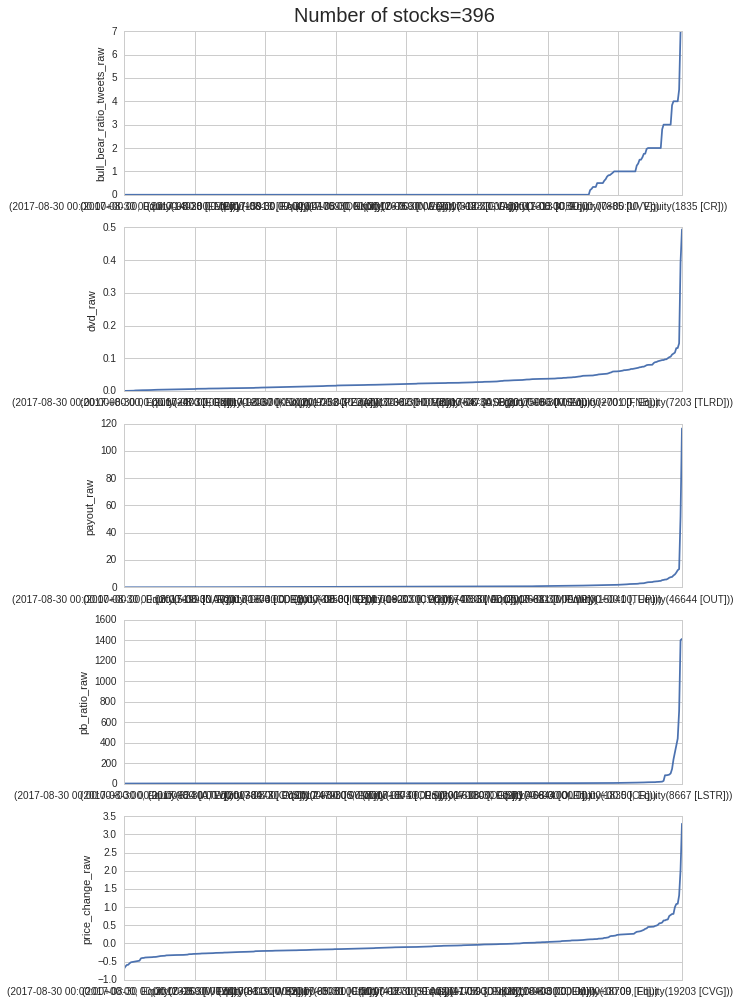

In [21]:
f,ax=plt.subplots(nrows=len(result.columns),figsize=(10,17))
for j,c in enumerate(result_dropnan.dropna()):
    result.dropna().sort_values(c)[c].plot(ax=ax[j])
    ax[j].set_ylabel(c)
f.suptitle( 'Number of stocks={}'.format(len(result_dropnan)),fontsize=20,y=0.92 )

### Diagnostic Plots
PB Ratio

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0767eb6990>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0767181790>], dtype=object)

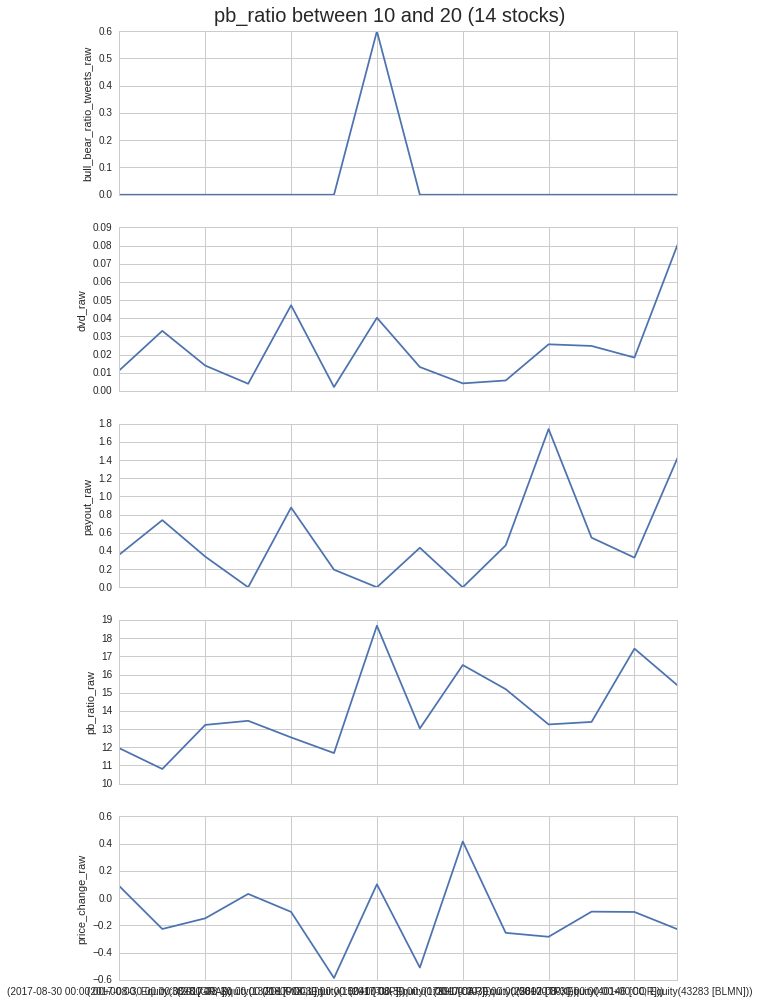

In [22]:
low, high=10,20
pbratio_filter=result_dropnan[(result_dropnan.pb_ratio_raw>low) & (result_dropnan.pb_ratio_raw<high)]
diagplot(pbratio_filter, 'pb_ratio between {0} and {1} ({2} stocks)'.format(low,high,len(pbratio_filter)))

In [23]:
pbratio_filter

bull_bear_ratio_tweets_raw  \
2017-08-30 00:00:00+00:00 Equity(3328 [GRA])                           0.0   
                          Equity(5809 [PCH])                           0.0   
                          Equity(13718 [POOL])                         0.0   
                          Equity(14972 [NBIX])                         0.0   
                          Equity(15041 [TUP])                          0.0   
                          Equity(15365 [PEGA])                         0.0   
                          Equity(17991 [CAR])                          0.6   
                          Equity(21697 [NTRI])                         0.0   
                          Equity(25802 [TPX])                          0.0   
                          Equity(26496 [BLKB])                         0.0   
                          Equity(40146 [COR])                          0.0   
                          Equity(41759 [DNKN])                         0.0   
                          Equity(43283 [BLMN])                         0.0   
                          Equity(44249 [APAM])                         0.0   

                                                dvd_raw  payout_raw  \
2017-08-30 00:00:00+00:00 Equity(3328 [GRA])     0.0114      0.3602   
                          Equity(5809 [PCH])     0.0331      0.7389   
                          Equity(13718 [POOL])   0.0140      0.3377   
                          Equity(14972 [NBIX])   0.0040      0.0000   
                          Equity(15041 [TUP])    0.0472      0.8774   
                          Equity(15365 [PEGA])   0.0022      0.1935   
                          Equity(17991 [CAR])    0.0403      0.0000   
                          Equity(21697 [NTRI])   0.0132      0.4348   
                          Equity(25802 [TPX])    0.0042      0.0000   
                          Equity(26496 [BLKB])   0.0058      0.4615   
                          Equity(40146 [COR])    0.0257      1.7414   
                          Equity(41759 [DNKN])   0.0248      0.5461   
                          Equity(43283 [BLMN])   0.0184      0.3261   
                          Equity(44249 [APAM])   0.0803      1.4201   

                                                pb_ratio_raw  price_change_raw  
2017-08-30 00:00:00+00:00 Equity(3328 [GRA])         11.9431          0.086722  
                          Equity(5809 [PCH])         10.8007         -0.227182  
                          Equity(13718 [POOL])       13.2264         -0.148869  
                          Equity(14972 [NBIX])       13.4516          0.030176  
                          Equity(15041 [TUP])        12.5381         -0.101692  
                          Equity(15365 [PEGA])       11.6763         -0.586826  
                          Equity(17991 [CAR])        18.6861          0.100827  
                          Equity(21697 [NTRI])       13.0307         -0.510211  
                          Equity(25802 [TPX])        16.5213          0.414867  
                          Equity(26496 [BLKB])       15.1928         -0.255451  
                          Equity(40146 [COR])        13.2521         -0.284325  
                          Equity(41759 [DNKN])       13.3902         -0.099937  
                          Equity(43283 [BLMN])       17.4231         -0.102367  
                          Equity(44249 [APAM])       15.4086         -0.228785

Dividend

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0767643810>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f076681b1d0>], dtype=object)

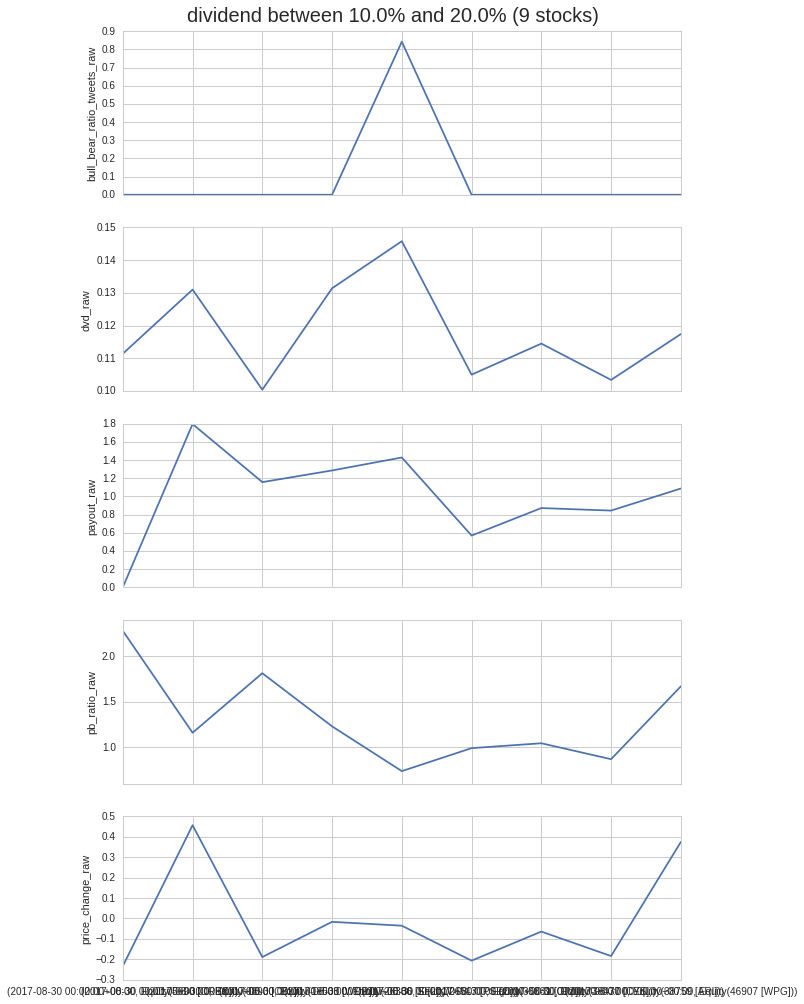

In [24]:
low, high=0.1,0.2
dvd_filter=result_dropnan[(result_dropnan.dvd_raw>0.1) & (result_dropnan.dvd_raw<0.2)]
diagplot(dvd_filter, 'dividend between {0}% and {1}% ({2} stocks)'\
         .format(low*100,high*100,len(dvd_filter)))

In [25]:
dvd_filter

bull_bear_ratio_tweets_raw  \
2017-08-30 00:00:00+00:00 Equity(5690 [ORBK])                       0.0000   
                          Equity(9890 [CBL])                        0.0000   
                          Equity(18508 [WDR])                       0.0000   
                          Equity(26386 [SFL])                       0.0000   
                          Equity(26517 [PSEC])                      0.8421   
                          Equity(35081 [CIM])                       0.0000   
                          Equity(38477 [CYS])                       0.0000   
                          Equity(38759 [ARI])                       0.0000   
                          Equity(46907 [WPG])                       0.0000   

                                                dvd_raw  payout_raw  \
2017-08-30 00:00:00+00:00 Equity(5690 [ORBK])    0.1114      0.0000   
                          Equity(9890 [CBL])     0.1310      1.7966   
                          Equity(18508 [WDR])    0.1004      1.1572   
                          Equity(26386 [SFL])    0.1314      1.2857   
                          Equity(26517 [PSEC])   0.1458      1.4285   
                          Equity(35081 [CIM])    0.1050      0.5690   
                          Equity(38477 [CYS])    0.1145      0.8718   
                          Equity(38759 [ARI])    0.1034      0.8440   
                          Equity(46907 [WPG])    0.1174      1.0870   

                                                pb_ratio_raw  price_change_raw  
2017-08-30 00:00:00+00:00 Equity(5690 [ORBK])         2.2805         -0.233075  
                          Equity(9890 [CBL])          1.1592          0.456118  
                          Equity(18508 [WDR])         1.8141         -0.188568  
                          Equity(26386 [SFL])         1.2293         -0.016499  
                          Equity(26517 [PSEC])        0.7366         -0.035350  
                          Equity(35081 [CIM])         0.9897         -0.206286  
                          Equity(38477 [CYS])         1.0433         -0.064147  
                          Equity(38759 [ARI])         0.8679         -0.183822  
                          Equity(46907 [WPG])         1.6696          0.374166

Payout

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0766663c90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f076635a8d0>], dtype=object)

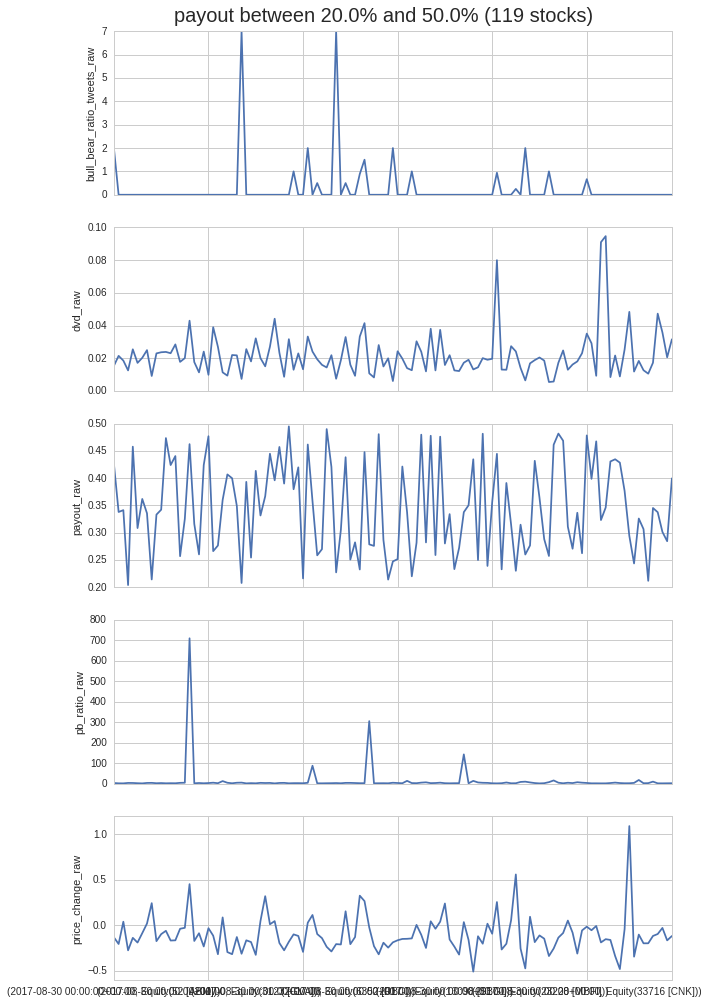

In [26]:
low,high=0.2,0.5
payout_filter=result_dropnan[(result_dropnan.payout_raw>low) & (result_dropnan.payout_raw<high)]
diagplot(payout_filter, 'payout between {0}% and {1}% ({2} stocks)'.format(low*100,high*100,len(payout_filter)))

In [27]:
payout_filter

bull_bear_ratio_tweets_raw  \
2017-08-30 00:00:00+00:00 Equity(52 [ABM])                          2.0000   
                          Equity(547 [ASB])                         0.0000   
                          Equity(661 [AVT])                         0.0000   
                          Equity(755 [BC])                          0.0000   
                          Equity(1023 [BOH])                        0.0000   
                          Equity(1028 [BXS])                        0.0000   
                          Equity(1062 [BPOP])                       0.0000   
                          Equity(1234 [CAKE])                       0.0000   
                          Equity(1266 [CASY])                       0.0000   
                          Equity(1270 [CATY])                       0.0000   
                          Equity(1315 [CBT])                        0.0000   
                          Equity(1490 [CHFC])                       0.0000   
                          Equity(1755 [COLB])                       0.0000   
                          Equity(1995 [CUZ])                        0.0000   
                          Equity(2212 [DLX])                        0.0000   
                          Equity(2295 [LCII])                       0.0000   
                          Equity(2404 [EAT])                        0.0000   
                          Equity(2891 [FMBI])                       0.0000   
                          Equity(3065 [FUL])                        0.0000   
                          Equity(3066 [FULT])                       0.0000   
                          Equity(3123 [GVA])                        0.0000   
                          Equity(3128 [TGNA])                       0.0000   
                          Equity(3266 [GATX])                       0.0000   
                          Equity(3328 [GRA])                        0.0000   
                          Equity(3471 [HRC])                        0.0000   
                          Equity(3476 [HBHC])                       0.0000   
                          Equity(3661 [HLS])                        0.0000   
                          Equity(4433 [LFUS])                       7.0000   
                          Equity(4488 [LM])                         0.0000   
                          Equity(4621 [LZB])                        0.0000   
...                                                                    ...   
                          Equity(25679 [NXST])                      0.0000   
                          Equity(25712 [AHL])                       0.0000   
                          Equity(26204 [FHN])                       0.0000   
                          Equity(26305 [CHE])                       1.0000   
                          Equity(26496 [BLKB])                      0.0000   
                          Equity(26693 [TXRH])                      0.0000   
                          Equity(27703 [ISBC])                      0.0000   
                          Equity(32159 [MWA])                       0.0000   
                          Equity(32302 [HOMB])                      0.0000   
                          Equity(32483 [EVR])                       0.0000   
                          Equity(33016 [ALGT])                      0.0000   
                          Equity(33716 [CNK])                       0.6667   
                          Equity(34334 [VR])                        0.0000   
                          Equity(34560 [CZZ])                       0.0000   
                          Equity(35162 [ARR])                       0.0000   
                          Equity(38531 [IVR])                       0.0000   
                          Equity(39363 [FNGN])                      0.0000   
                          Equity(40445 [LPLA])                      0.0000   
                          Equity(40530 [TROX])                      0.0000   
                          Equity(40783 [BKU])                       0.

Price Change

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0768fe44d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f075f728310>], dtype=object)

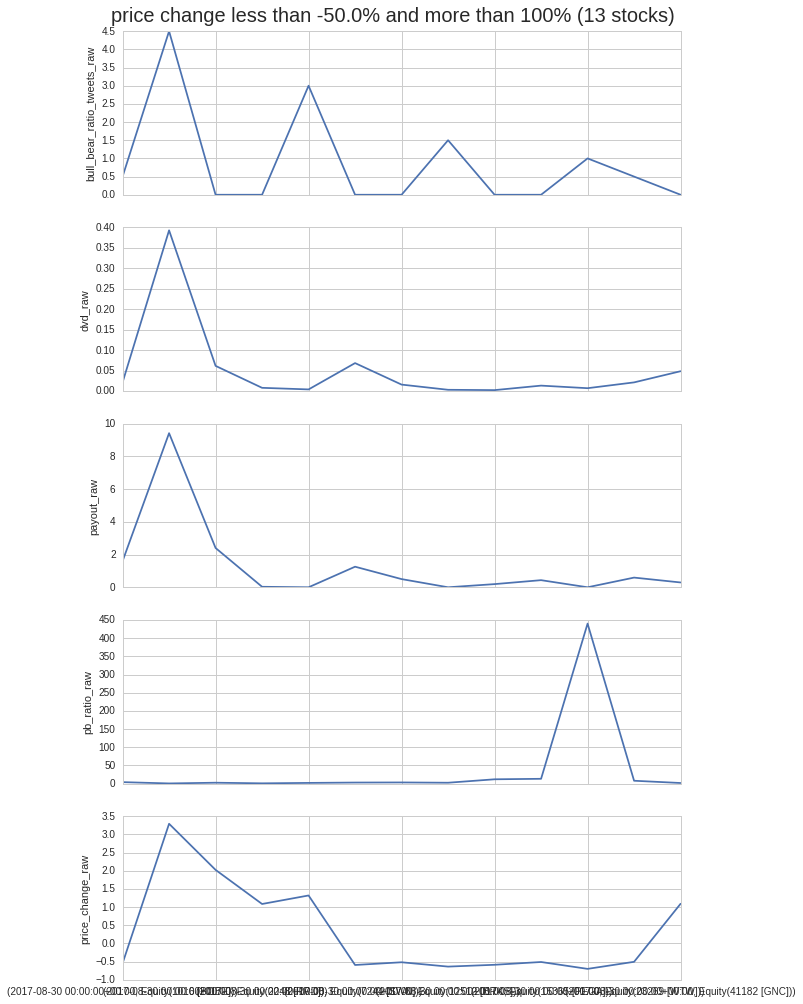

In [28]:
low,high=-0.5,1
pc_filter=result_dropnan[(result_dropnan.price_change_raw < low) | (result_dropnan.price_change_raw > high)]
diagplot(pc_filter, 'price change less than {0}% and more than {1}% ({2} stocks)'.\
         format(low*100,high*100,len(pc_filter)))

In [29]:
pc_filter

bull_bear_ratio_tweets_raw  \
2017-08-30 00:00:00+00:00 Equity(1016 [BOBE])                          0.5   
                          Equity(2069 [FTR])                           4.5   
                          Equity(2248 [RRD])                           0.0   
                          Equity(4664 [SM])                            0.0   
                          Equity(7244 [SWN])                           3.0   
                          Equity(11710 [GEO])                          0.0   
                          Equity(12512 [BRKS])                         0.0   
                          Equity(14484 [CENX])                         1.5   
                          Equity(15365 [PEGA])                         0.0   
                          Equity(21697 [NTRI])                         0.0   
                          Equity(23269 [WTW])                          1.0   
                          Equity(25867 [PETS])                         0.5   
                          Equity(41182 [GNC])                          0.0   

                                                dvd_raw  payout_raw  \
2017-08-30 00:00:00+00:00 Equity(1016 [BOBE])    0.0211      1.6000   
                          Equity(2069 [FTR])     0.3930      9.4228   
                          Equity(2248 [RRD])     0.0615      2.4026   
                          Equity(4664 [SM])      0.0078      0.0301   
                          Equity(7244 [SWN])     0.0039      0.0000   
                          Equity(11710 [GEO])    0.0683      1.2581   
                          Equity(12512 [BRKS])   0.0157      0.5000   
                          Equity(14484 [CENX])   0.0030      0.0000   
                          Equity(15365 [PEGA])   0.0022      0.1935   
                          Equity(21697 [NTRI])   0.0132      0.4348   
                          Equity(23269 [WTW])    0.0069      0.0000   
                          Equity(25867 [PETS])   0.0211      0.5923   
                          Equity(41182 [GNC])    0.0484      0.2943   

                                                pb_ratio_raw  price_change_raw  
2017-08-30 00:00:00+00:00 Equity(1016 [BOBE])         3.8654         -0.546108  
                          Equity(2069 [FTR])          0.2983          3.292947  
                          Equity(2248 [RRD])          2.3015          2.024331  
                          Equity(4664 [SM])           0.5729          1.085771  
                          Equity(7244 [SWN])          1.7609          1.320261  
                          Equity(11710 [GEO])         2.7225         -0.592372  
                          Equity(12512 [BRKS])        3.0115         -0.517521  
                          Equity(14484 [CENX])        2.2424         -0.636878  
                          Equity(15365 [PEGA])       11.6763         -0.586826  
                          Equity(21697 [NTRI])       13.0307         -0.510211  
                          Equity(23269 [WTW])       440.0219         -0.699297  
                          Equity(25867 [PETS])        7.6926         -0.505139  
                          Equity(41182 [GNC])         1.4822          1.091688